# CSC 3105 Project

# Load and Clean the Data

This code block performs the following operations:

1. Imports necessary libraries for data handling and cleaning.
2. Defines a function `load_data` to load the data from a given directory into a pandas dataframe.
3. Defines a function `clean_data` to clean the loaded data. The cleaning process includes:
   - Handling missing values by dropping them.
   - Removing duplicate rows.
   - Converting the 'NLOS' column to integer data type.
   - Normalizing the 'Measured range (time of flight)' column.
   - Creating new features 'FP_SUM' and 'SNR'.
   - One-hot encoding categorical features.
   - Performing feature extraction on 'CIR' columns.
   - Dropping the original 'CIR' columns.
   - Checking for columns with only one unique value and dropping them.
4. Checks if a pickle file with the cleaned data exists. If it does, it loads the data from the file. If it doesn't, it loads and cleans the data using the defined functions.
5. Prints the first few rows of the cleaned data and its column headers.

In [249]:
import os

import pandas as pd

DATASET_DIR = './UWB-LOS-NLOS-Data-Set/dataset'


def load_data(dataset_dir):
    # Load the data
    # file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames if 'uwb_dataset_part7.csv' not in file]
    file_paths = [os.path.join(dirpath, file) for dirpath, _, filenames in os.walk(dataset_dir) for file in filenames]
    data = pd.concat((pd.read_csv(file_path) for file_path in file_paths))
    print(f"Original data shape: {data.shape}")
    return data


In [250]:
def stat_analysis_and_plots(data):
    # Statistical Analysis
    print("Statistical Analysis:")
    print(data.describe())

    # Plot Boxplot to check for outliers for the first 15 columns
    print("Boxplot of the first 15 columns:")
    fig, axs = plt.subplots(15,1,dpi=95, figsize=(7,17))
    for i, col in enumerate(data.columns[:15]):
        axs[i].boxplot(data[col], vert=False)
        axs[i].set_ylabel(col)
    plt.show()


In [251]:
import matplotlib.pyplot as plt
import numpy as np

def cir_graphs(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the CIR columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    data_los_cir = data_los[cir_columns]
    data_nlos_cir = data_nlos[cir_columns]

    # Calculate the magnitude and time for each CIR column
    time_los = np.arange(len(data_los_cir.columns))
    magnitude_los = np.linalg.norm(data_los_cir.values, axis=0)

    time_nlos = np.arange(len(data_nlos_cir.columns))
    magnitude_nlos = np.linalg.norm(data_nlos_cir.values, axis=0)

    # Plot the magnitude vs time for LOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_los, magnitude_los, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for LOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    plt.show()

    # Plot the magnitude vs time for NLOS
    plt.figure(figsize=(20, 10), dpi=300)  # Increase figure size and DPI
    plt.plot(time_nlos, magnitude_nlos, linewidth=2)  # Increase line width
    plt.title('Magnitude vs Time for NLOS')
    plt.xlabel('Time (ns)')
    plt.ylabel('Magnitude')
    plt.xlim([600, max(time_los)])  # Set x-axis limits
    plt.show()
    

In [252]:

def snr_graph(data):
    # Separate the data into LOS and NLOS
    data_los = data[data['NLOS'] == 0]
    data_nlos = data[data['NLOS'] == 1]

    # Extract the SNR values
    snr_los = data_los['SNR']
    snr_nlos = data_nlos['SNR']

    # Create a new figure
    plt.figure(figsize=(10, 5))

    # Plot SNR for LOS
    plt.plot(snr_los, label='LOS')

    # Plot SNR for NLOS
    plt.plot(snr_nlos, color='red', label='NLOS')

    # Set title and labels
    plt.title('SNR for LOS and NLOS')
    plt.xlabel('Index')
    plt.ylabel('SNR')

    # Add a legend
    plt.legend()

    # Show the plot
    plt.show()
    

In [253]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pywt
from skimage import restoration

def denoise_cir(cir_values, wavelet='db1', level=1):
    # Perform wavelet decomposition
    coeffs = pywt.wavedec(cir_values, wavelet, level=level)

    # Set the detail coefficients to zero
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], value=0.5, mode='soft')

    # Perform wavelet reconstruction
    denoised_cir = pywt.waverec(coeffs, wavelet)

    return denoised_cir


def deconvolve_cir(cir_values, psf=None, iterations=50):
    # If no point spread function is provided, create a simple one
    if psf is None:
        psf = np.ones((5,)) / 5

    # Perform Richardson-Lucy deconvolution
    deconvolved_cir = restoration.richardson_lucy(cir_values, psf, num_iter=iterations)

    return deconvolved_cir

def clean_data(data):
    print("Starting data cleaning process...")
    
    # print("Before Cleaning")
    # stat_analysis_and_plots(data)

    # Calculate total number of missing values in the data
    total_missing = data.isnull().sum().sum()
    print(f"Total number of missing values: {total_missing}")

    # Data has no missing values
    data = data.dropna()
    print("Missing values dropped.")

    # Data has no duplicate rows
    data = data.drop_duplicates()
    print("Duplicate rows dropped.")

    # Convert 'NLOS' column to integer data type (0 for LOS, 1 for NLOS)
    data['NLOS'] = data['NLOS'].astype(int)
    print("'NLOS' column converted to integer data type.")
    
    # Print line where CIR_PWR is 0
    print(f"Line where CIR_PWR is 0: {data[data['CIR_PWR'] == 0]}")
    
    # Calculate the expression inside the log10 function
    # expression = (data['CIR_PWR'] * (2**17)) / (data['RXPACC']**2)
    # 
    # # If the expression is 0, set 'RX_Level' to 0
    # zero_indices = expression == 0
    # data.loc[zero_indices, 'RX_Level'] = 0

    # For the rest of the data where the expression is not 0, calculate 'RX_Level'
    # First, update the 'expression' and 'data' to exclude zero_indices
    # expression = expression.loc[~zero_indices]
    # data = data.loc[~zero_indices]
    # 
    # # Now, calculate 'RX_Level' for the rest of the data
    # data['RX_Level'] = 10 * np.log10(expression) - data['PRFR']
    # 
    # # Calculate the median of 'RX_Level'
    # median = data['RX_Level'].median()
    # 
    # # Create the boolean mask on the same DataFrame 'data'
    # zero_indices = (data['RX_Level'] == 0)
    # 
    # # Replace zero values in 'RX_Level' with the median
    # data.loc[zero_indices, 'RX_Level'] = median
    # 
    # print("New feature 'RX_Level' created.")

    # Calculate new feature 'First_Path_Power_Level'
    data['First_Path_Power_Level'] = (10 * np.log10(
        (data['FP_AMP1'] ** 2 + data['FP_AMP2'] ** 2 + data['FP_AMP3'] ** 2) / (data['RXPACC'] ** 2))) - 64
    print("New feature 'First_Path_Power_Level' calculated.")
    data.drop(['FP_AMP1', 'FP_AMP2', 'FP_AMP3', 'RXPACC', 'PRFR'], axis=1, inplace=True)

    # Calculate SNR as the ratio of 'CIR_PWR' to 'STDEV_NOISE' for each data point
    data['SNR'] = data['CIR_PWR'] / data['STDEV_NOISE']
    print("New feature 'SNR' created.")
    data.drop(['CIR_PWR', 'STDEV_NOISE'], axis=1, inplace=True)

    # One-hot encode categorical features
    categorical_features = ['CH', 'FRAME_LEN', 'PREAM_LEN', 'BITRATE']
    encoder = LabelEncoder()
    for feature in categorical_features:
        data[feature] = encoder.fit_transform(data[feature])
    print("Categorical features one-hot encoded.")

    # Extract the 'CIR' columns
    cir_columns = [col for col in data.columns if 'CIR' in col]
    cir_data = data[cir_columns]    
    print("'CIR' columns extracted.")
    
    # Convert 'CIR' columns to float
    cir_data = cir_data.astype(float)
    print("'CIR' columns converted to float.")
    
    # Denoise 'CIR' columns
    # denoised_cir_data = cir_data.apply(denoise_cir)
    denoised_cir_data = cir_data.apply(deconvolve_cir)
    print("'CIR' columns denoised.")
    
    # Replace original 'CIR' columns with denoised data
    data[cir_columns] = denoised_cir_data
    print("Original 'CIR' columns replaced with denoised data.")
    
    # Extract the 'CIR' columns
    # cir_columns = [f"CIR{i}" for i in range(1015)]
    # # cir_columns = [f"CIR{i}" for i in range(1016)]
    # cir_data = data[cir_columns]
    # print("'CIR' columns extracted.")
    # 
    # # Perform PCA on the 'CIR' columns
    # pca = PCA(n_components=0.95)
    # cir_pca = pca.fit_transform(cir_data)
    # print("PCA performed on 'CIR' columns.")
    # 
    # # Create a DataFrame with the principal components
    # cir_pca_df = pd.DataFrame(cir_pca, columns=[f"PC{i}" for i in range(1, pca.n_components_ + 1)])
    # print("DataFrame with principal components created.")
    # 
    # # Drop the original 'CIR' columns from the data
    # data = data.drop(columns=cir_columns)
    # print("Original 'CIR' columns dropped.")

    # Add the principal components to the original data
    # Reset the index of both dataframes
    # data = data.reset_index(drop=True)
    # cir_pca_df = cir_pca_df.reset_index(drop=True)
    # print("Indexes of both dataframes reset.")

    # Concatenate the dataframes
    # data = pd.concat([data, cir_pca_df], axis=1)
    # print("Dataframes concatenated.")

    # List of columns to check for unique values
    columns_to_check = ['CH', 'PREAM_LEN', 'BITRATE']

    # Iterate over the columns
    for column in columns_to_check:
        # If the column has only one unique value, drop it
        if data[column].nunique() == 1:
            data = data.drop(column, axis=1)
            print(f"Column '{column}' dropped due to having only one unique value.")

    # Standardize the numerical columns (excluding 'NLOS')
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    numerical_cols = numerical_cols.drop('NLOS')
    scaler = StandardScaler()
    data[numerical_cols] = scaler.fit_transform(data[numerical_cols])
    print("Numerical columns standardized.")

    # Print the shape of the cleaned data
    print(f"Cleaned data shape: {data.shape}")

    # print("After Cleaning")
    # stat_analysis_and_plots(data)
    
    print("Data cleaning process completed.")
    
    # Return the cleaned data
    return data

Pickle file not found. Loading and cleaning data...
Original data shape: (42000, 1031)


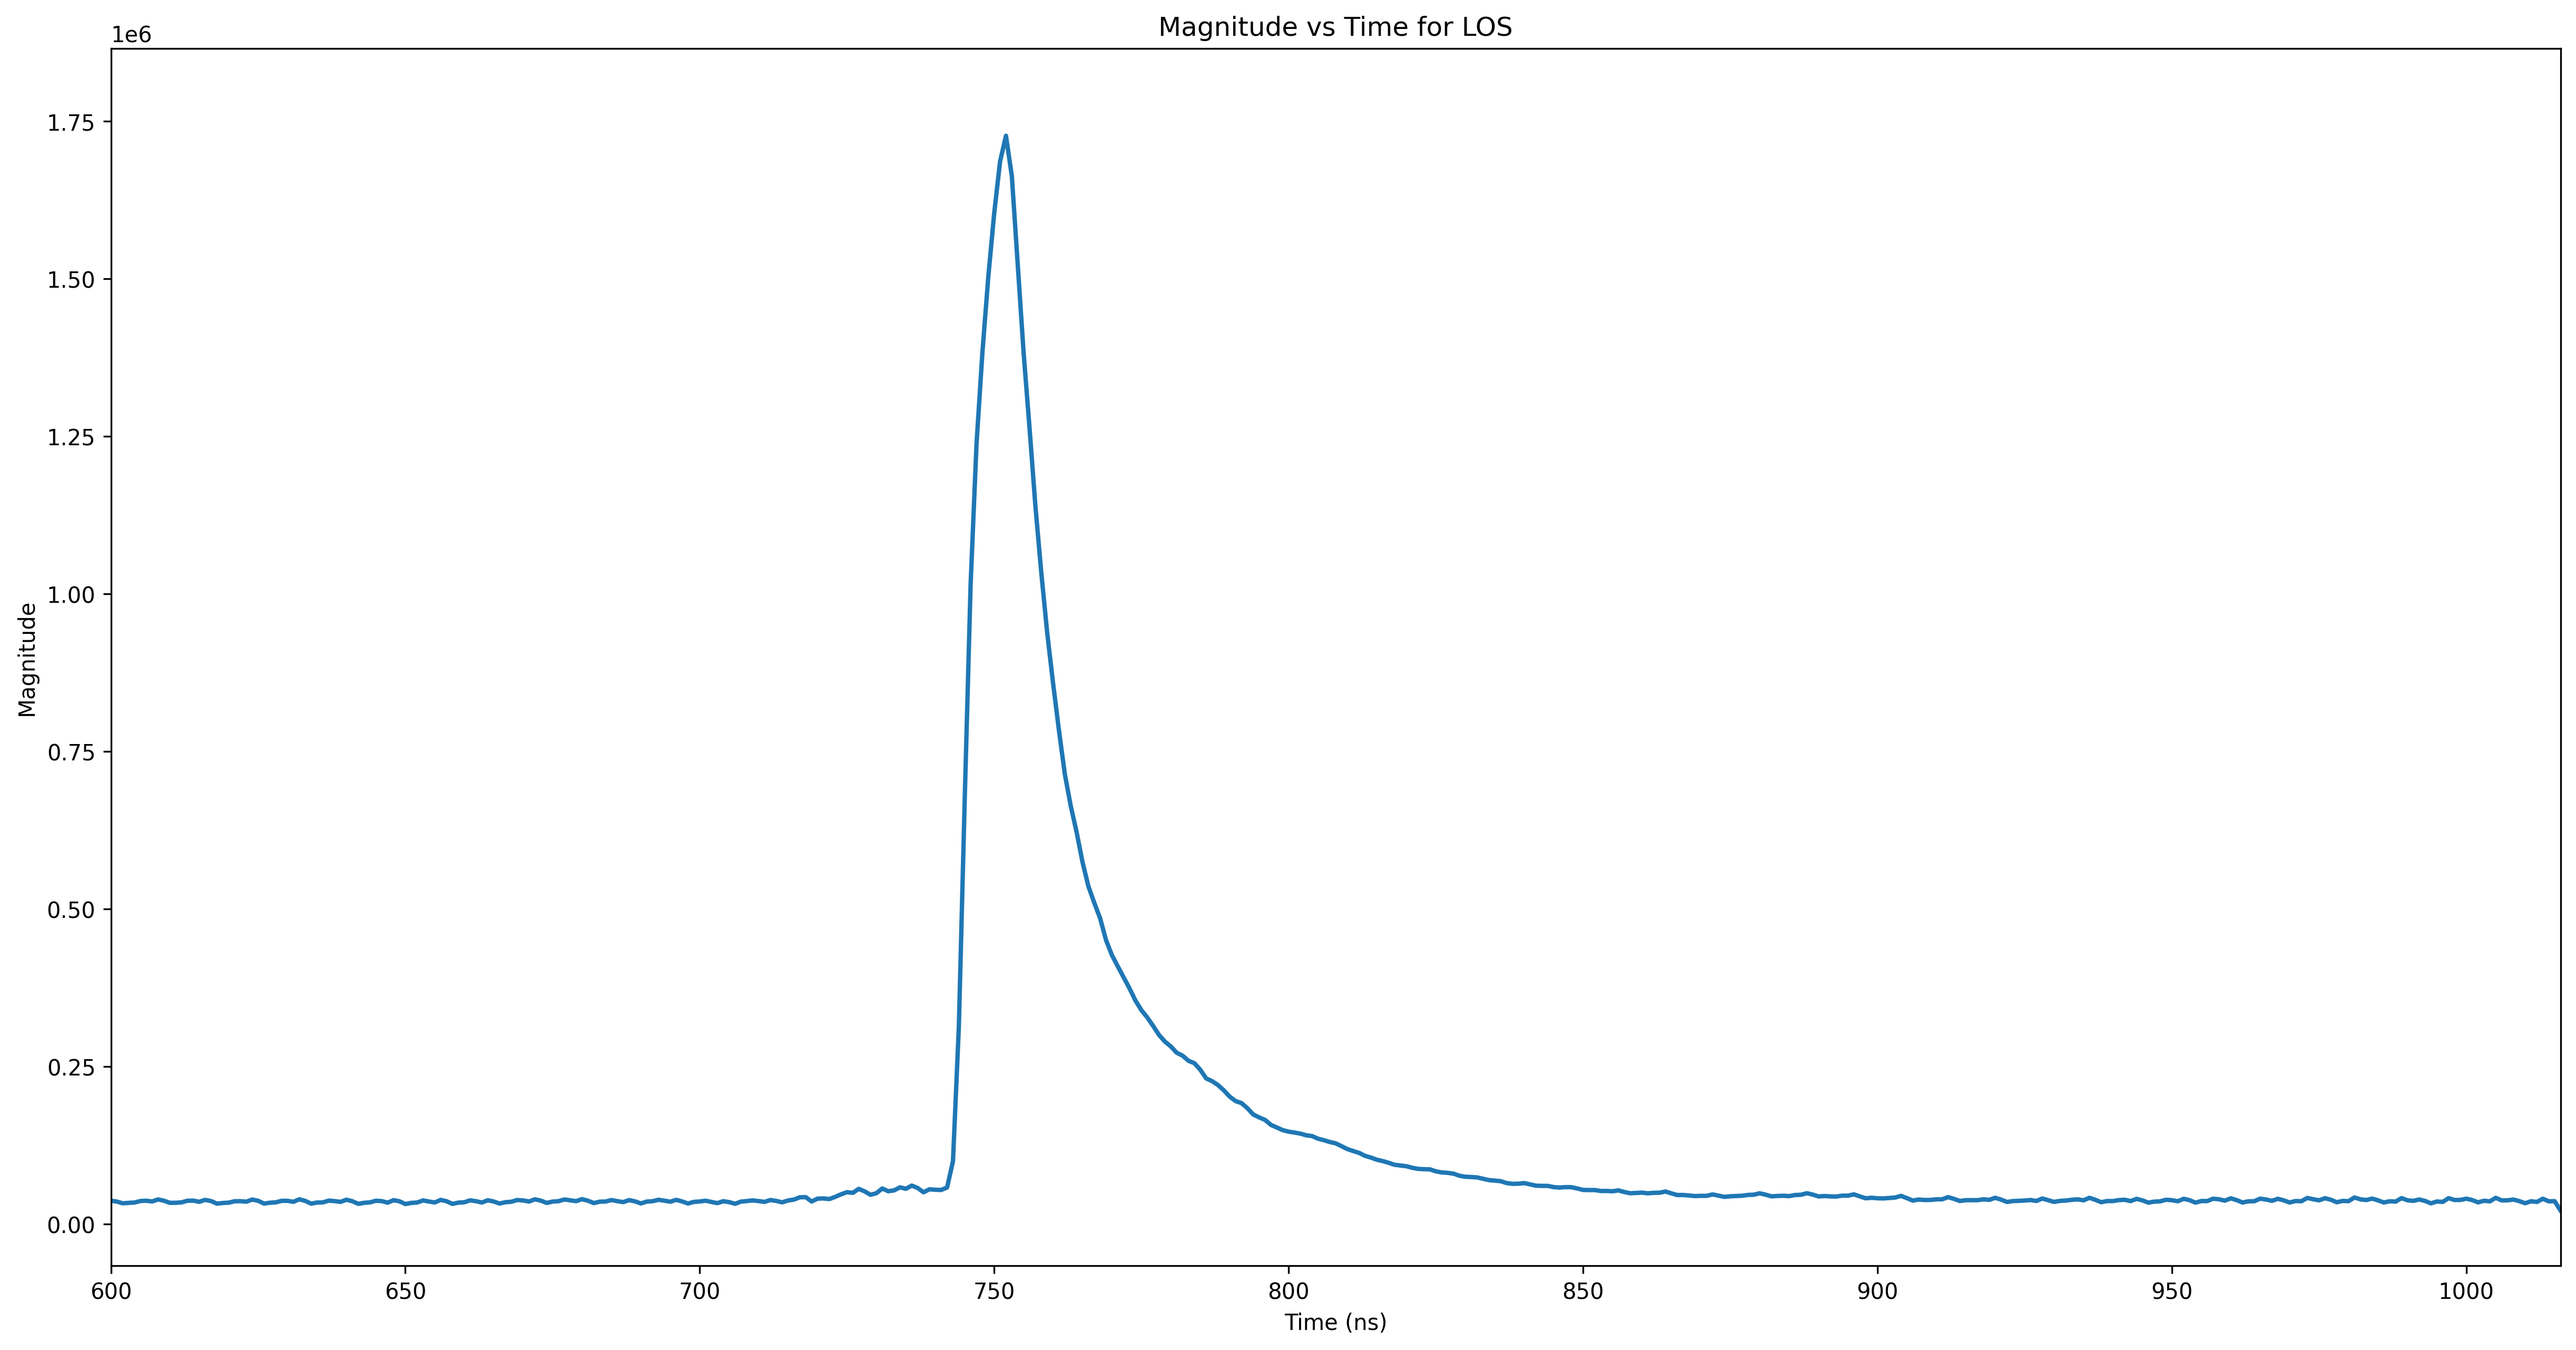

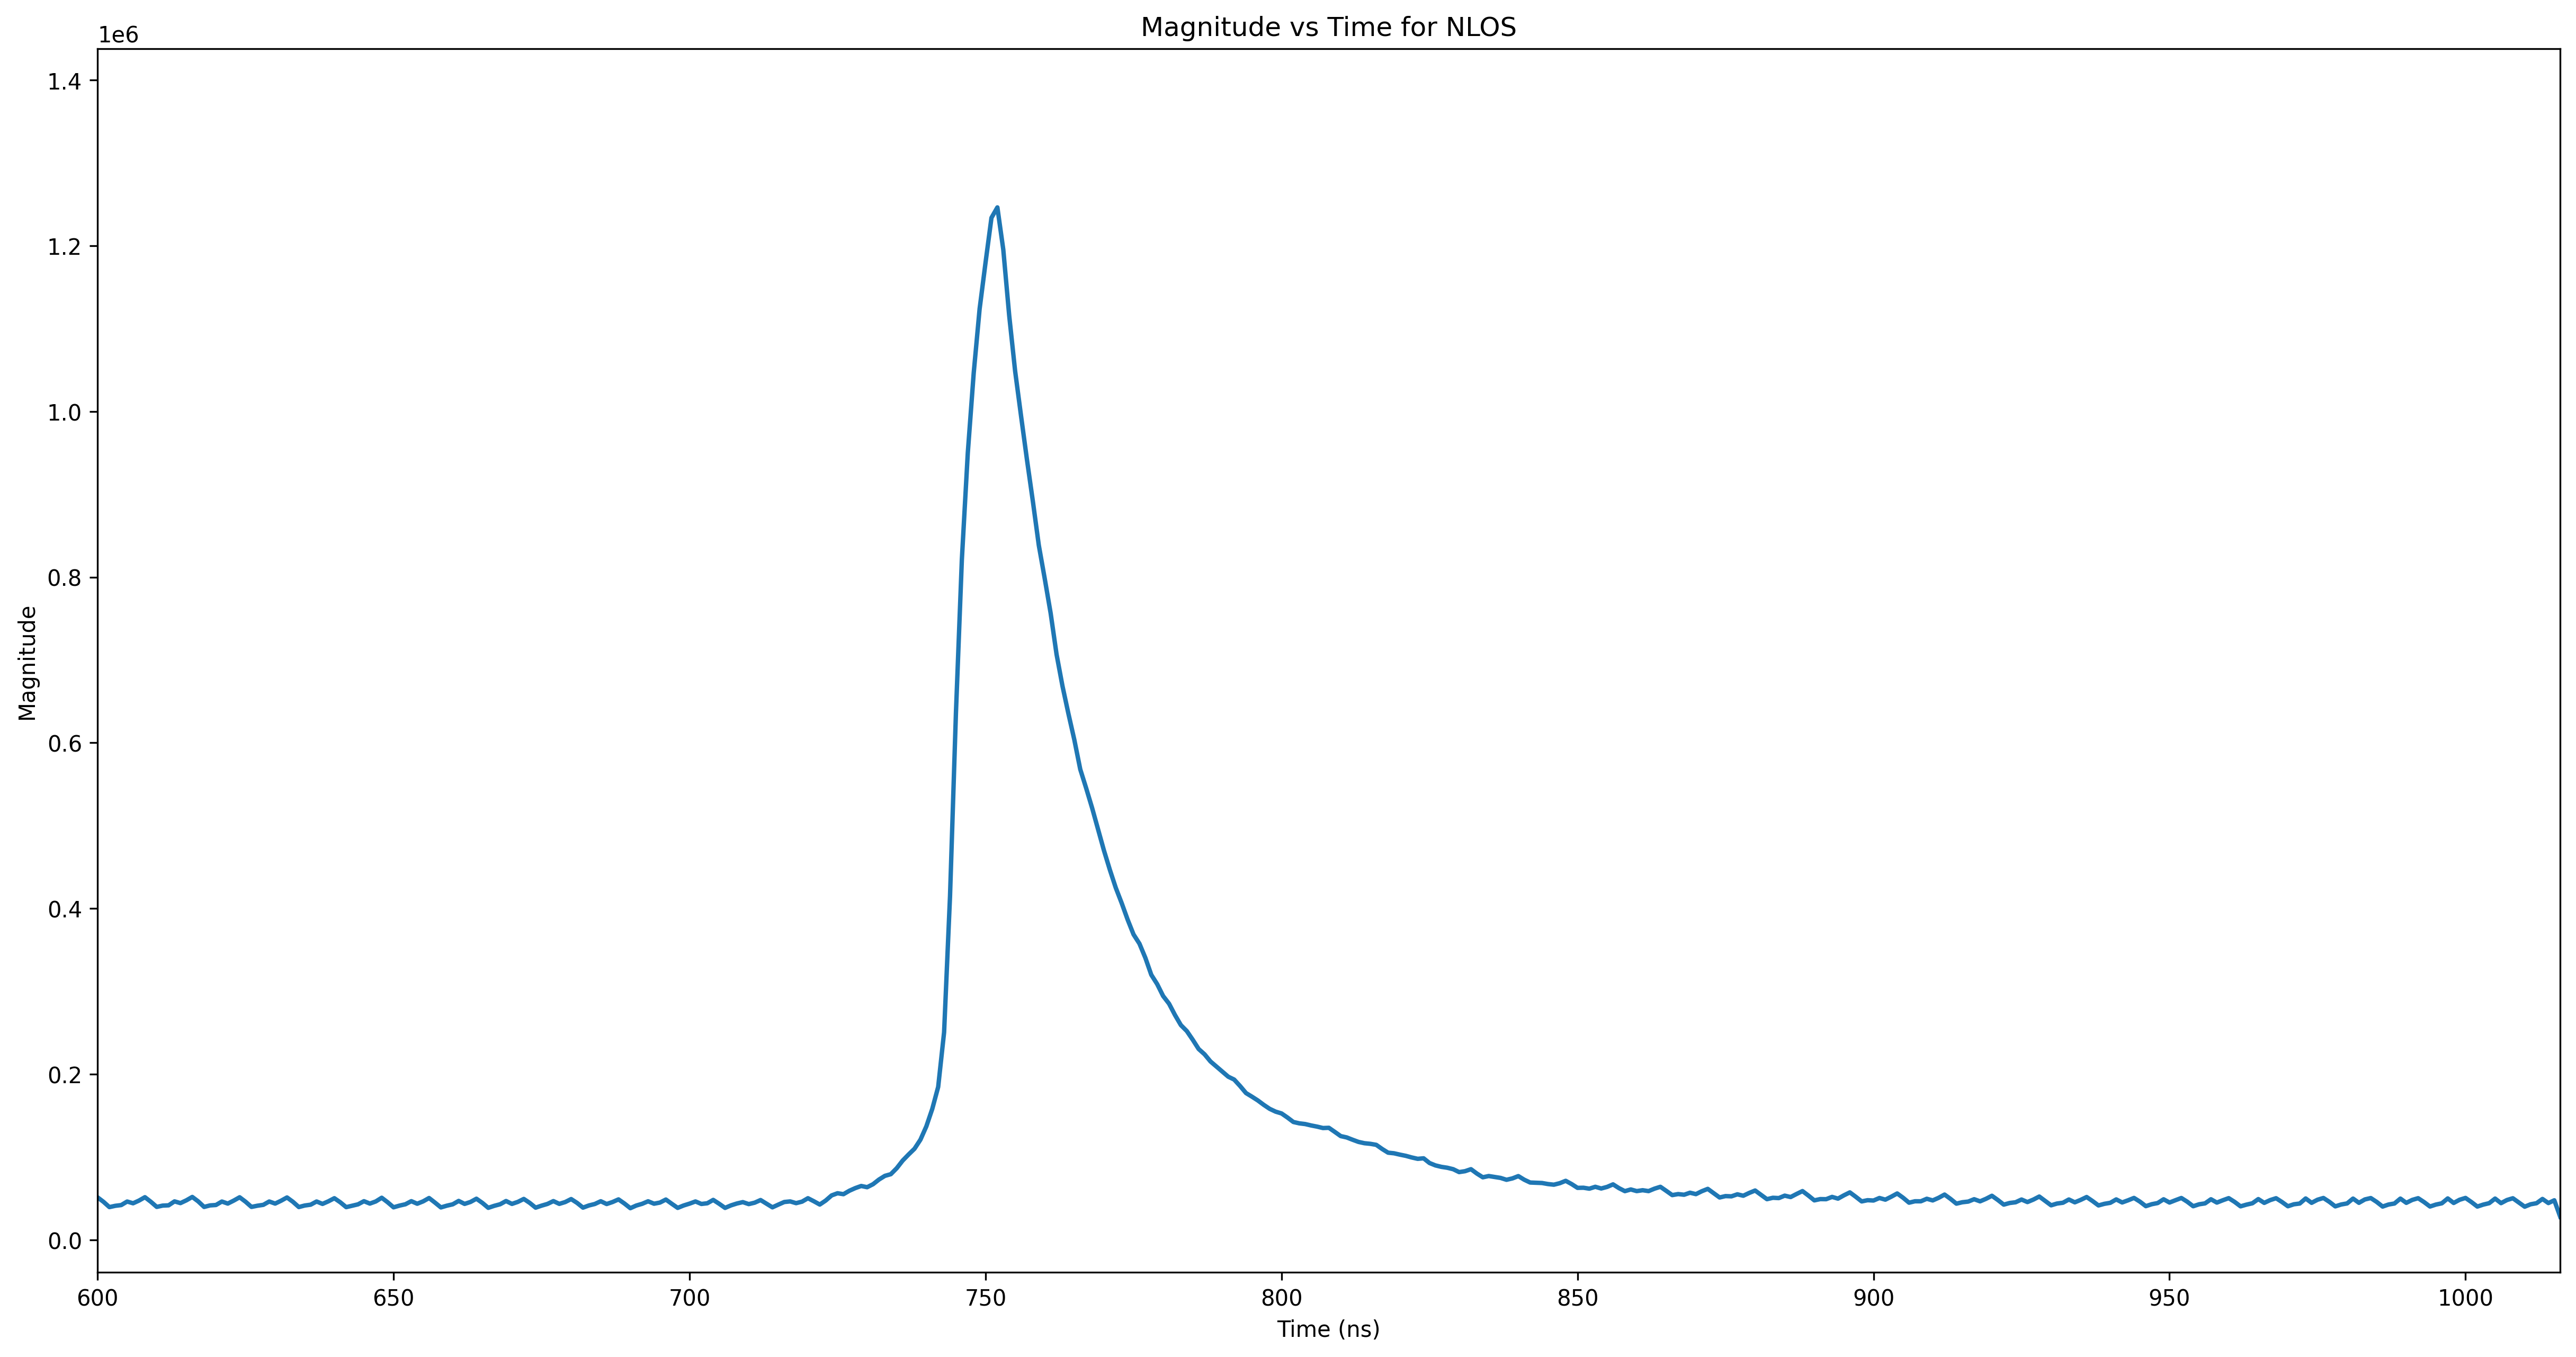

Starting data cleaning process...
Total number of missing values: 0
Missing values dropped.
Duplicate rows dropped.
'NLOS' column converted to integer data type.
Line where CIR_PWR is 0:       NLOS  RANGE  FP_IDX  FP_AMP1  FP_AMP2  FP_AMP3  STDEV_NOISE  CIR_PWR  \
4343     1   7.02   757.0     30.0    214.0    413.0         36.0      0.0   
837      1   4.88   739.0    112.0    323.0    227.0         40.0      0.0   
1356     1   6.33   747.0    293.0    311.0    187.0         28.0      0.0   

      MAX_NOISE  RXPACC  ...  CIR1006  CIR1007  CIR1008  CIR1009  CIR1010  \
4343      412.0   192.0  ...    252.0    271.0    190.0    292.0    271.0   
837       322.0   128.0  ...    161.0    219.0    295.0    242.0    279.0   
1356      310.0   160.0  ...    197.0     84.0    246.0    353.0    196.0   

      CIR1011  CIR1012  CIR1013  CIR1014  CIR1015  
4343    239.0    210.0    260.0    223.0    256.0  
837      67.0    153.0    177.0    159.0      0.0  
1356     38.0    228.0     42.0    

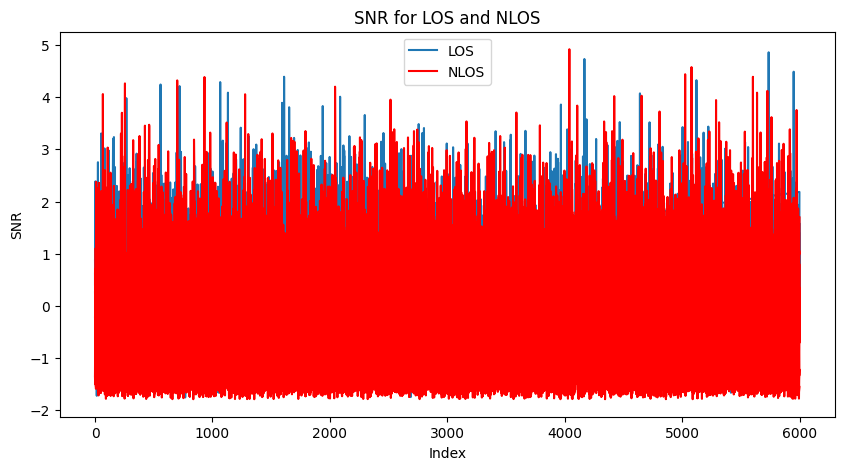

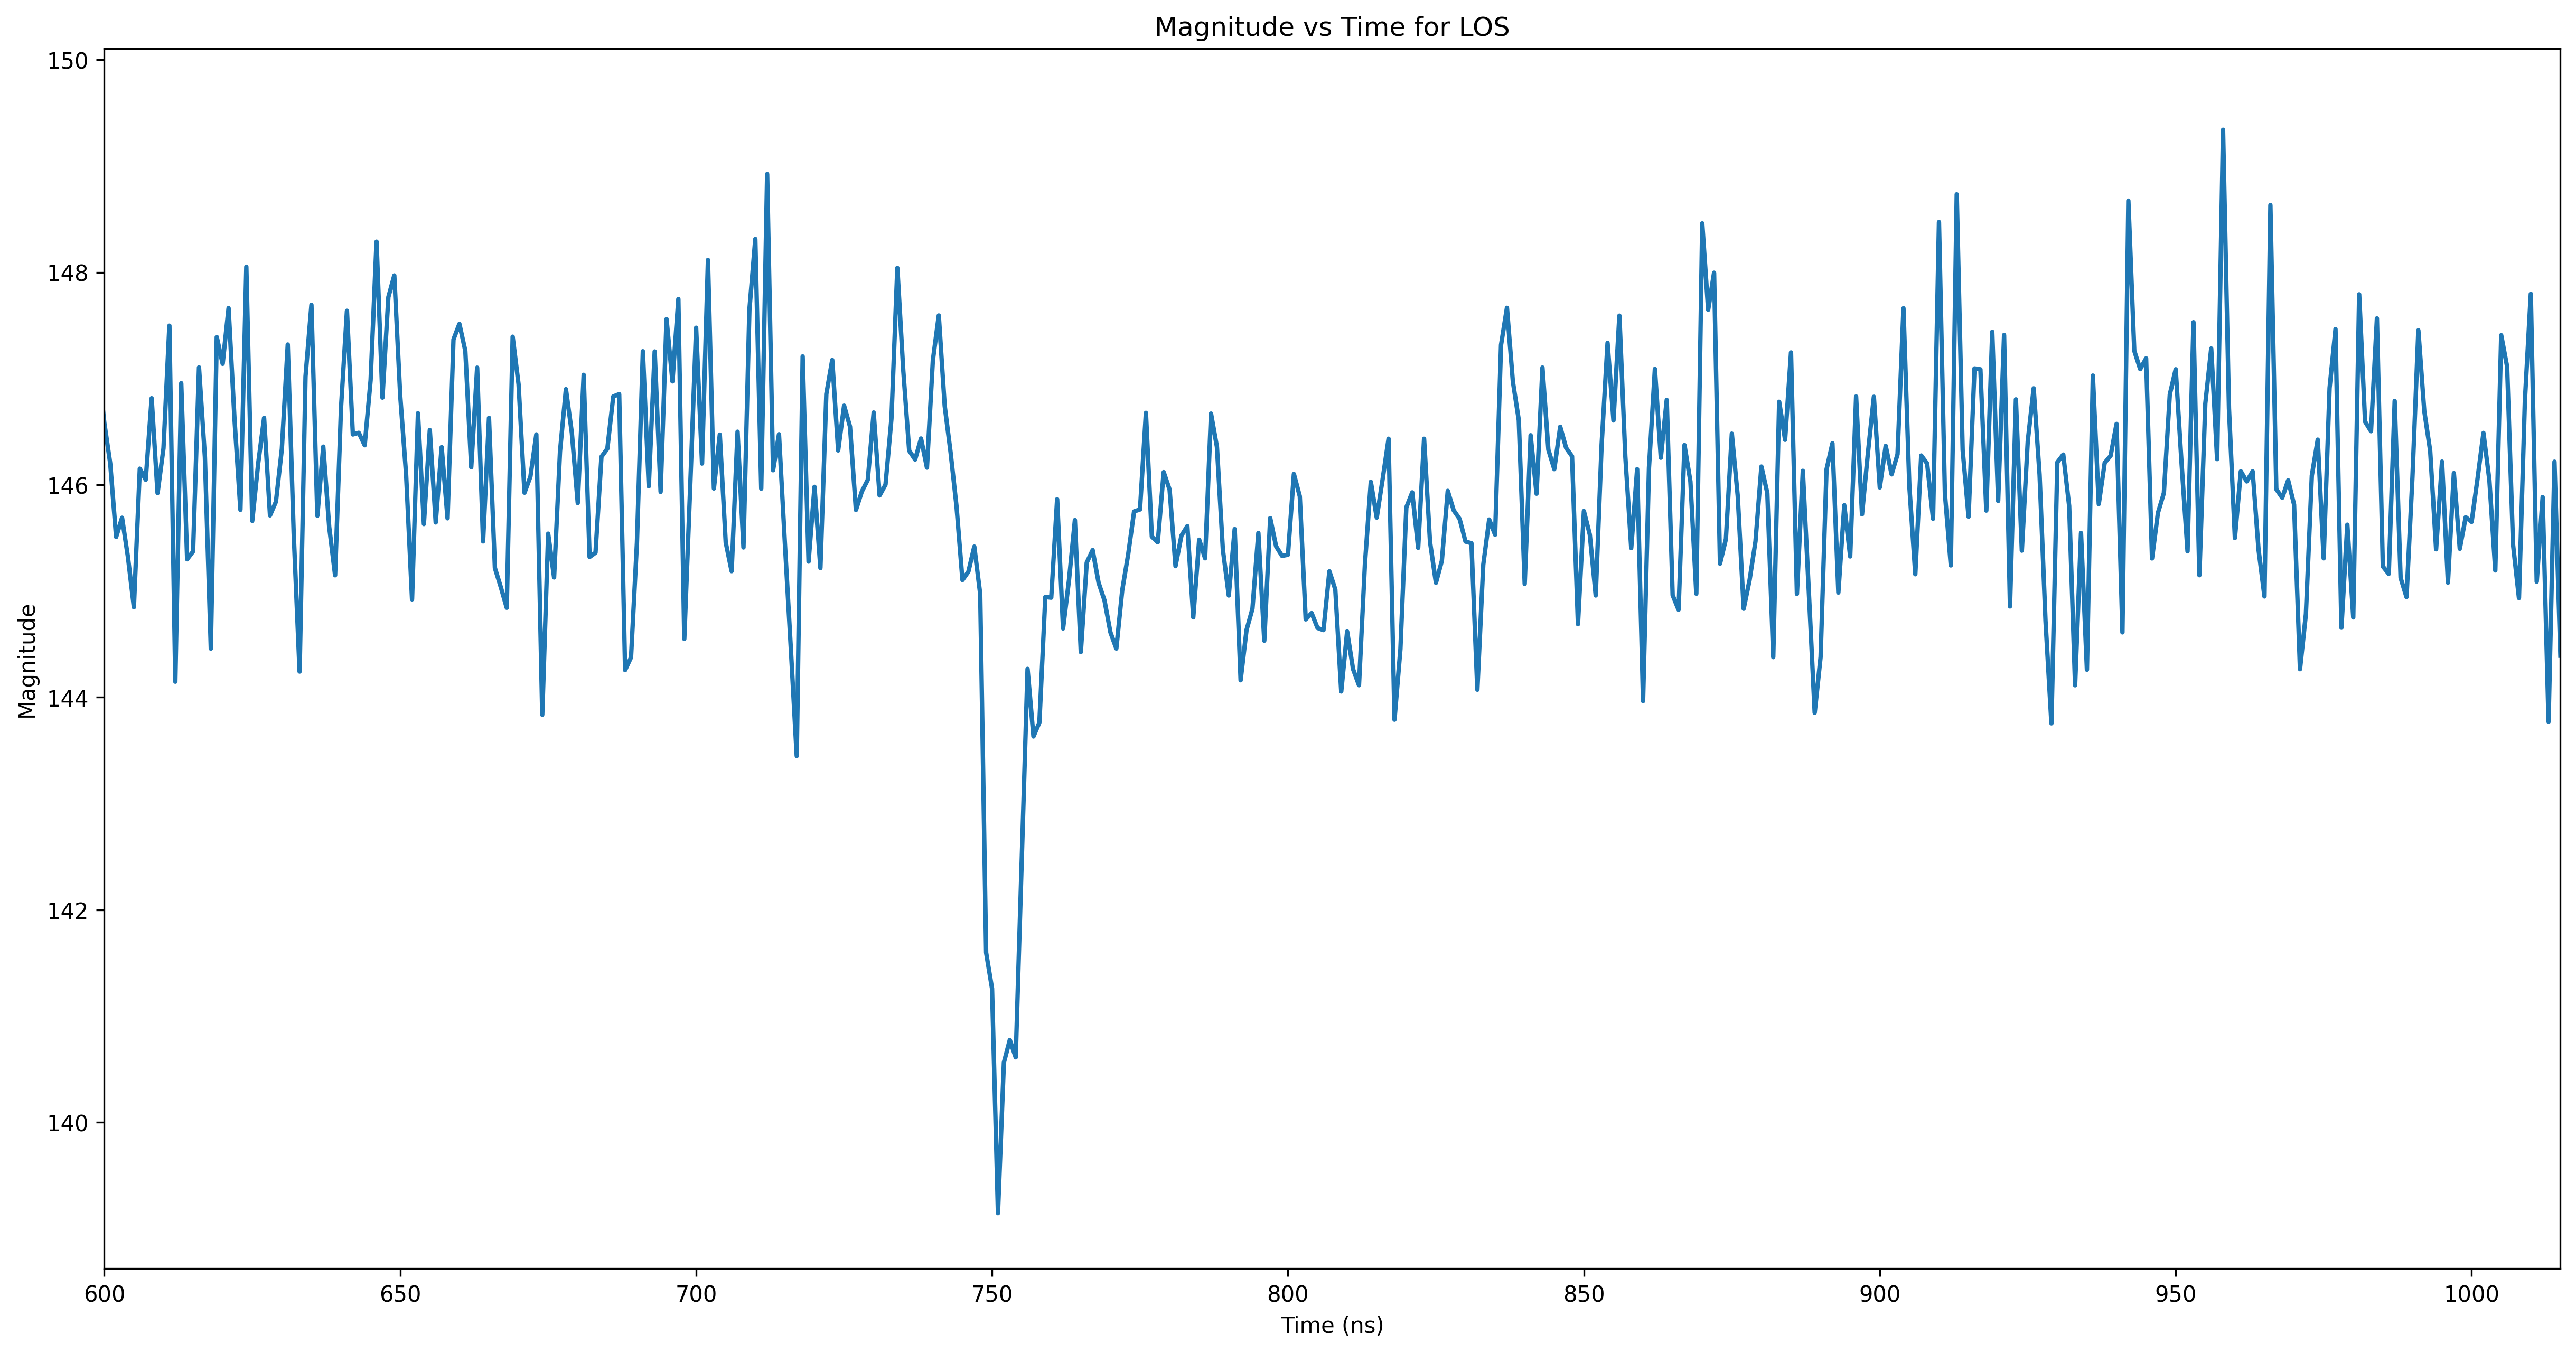

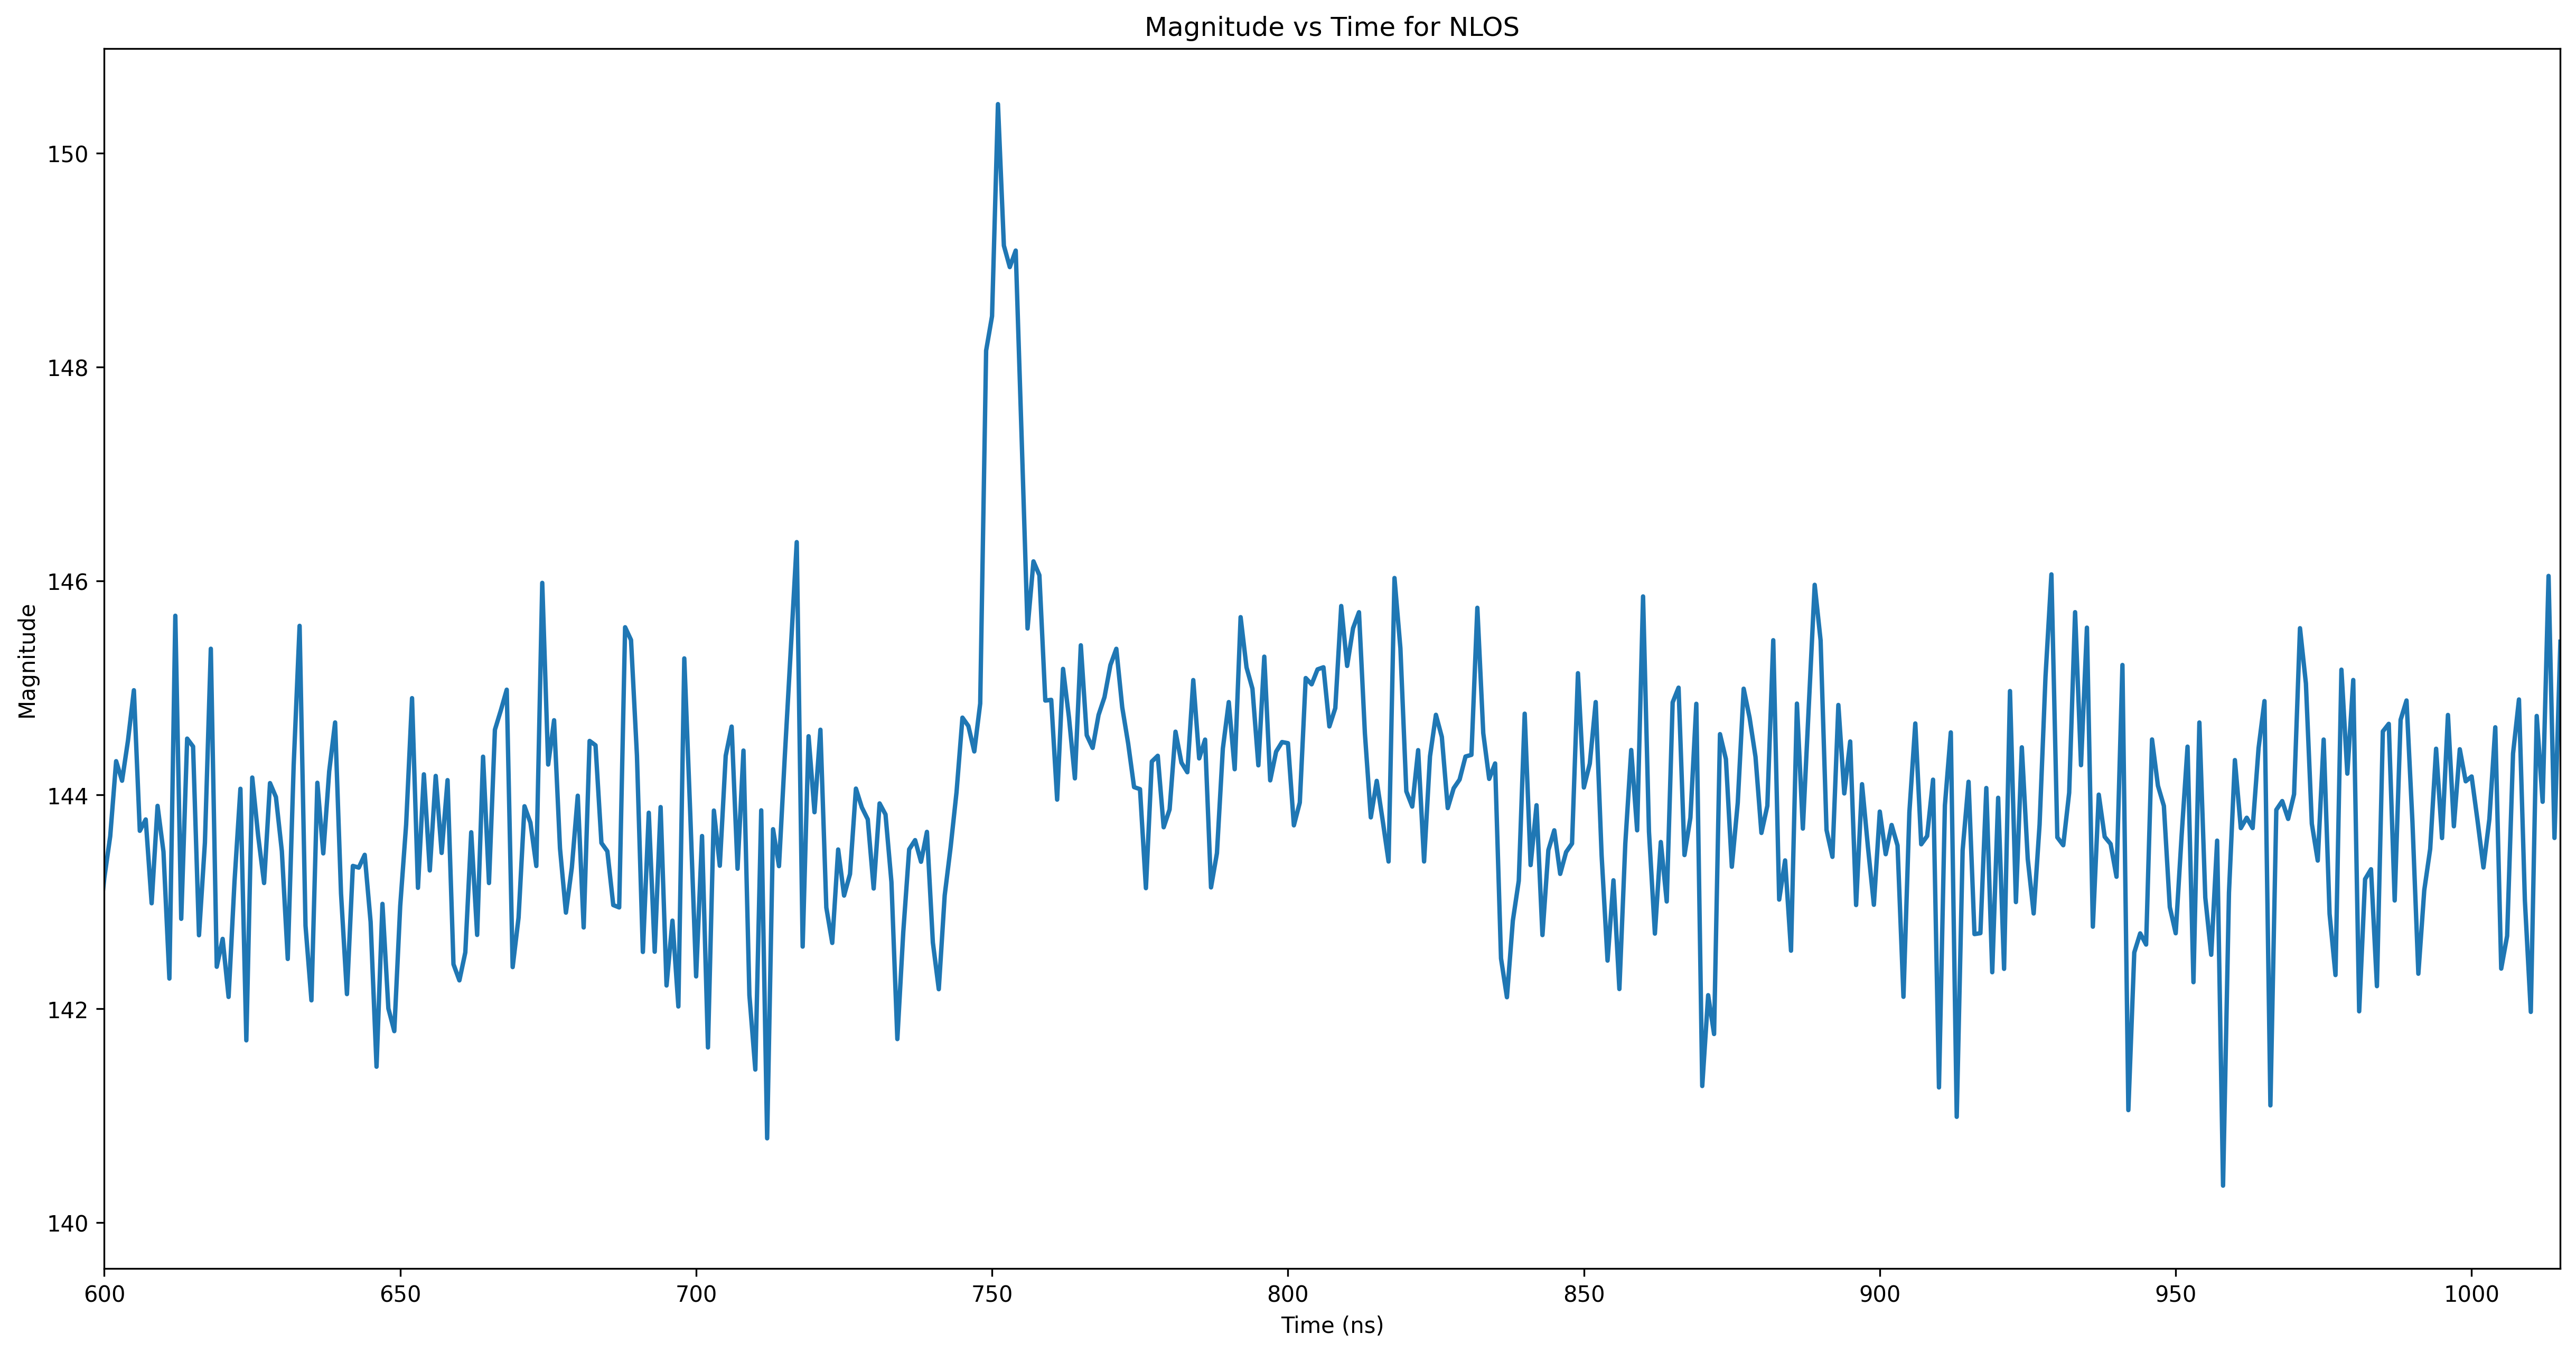

Data loaded and cleaned successfully.
Saving cleaned data to pickle file...
Cleaned data saved to pickle file successfully.
First few rows of the data:
   NLOS     RANGE    FP_IDX  MAX_NOISE  FRAME_LEN  PREAM_LEN      CIR0  \
0     1  0.996831  0.742698   4.038101   0.874210  -0.196211 -3.675820   
1     1  0.300720 -1.033118  -0.489497   0.874210  -0.196211  0.309636   
2     1  0.237051 -0.367187  -0.892980  -1.143918  -0.196211  0.309636   
3     1 -1.087256  0.520721   0.365545   0.874210  -0.196211 -3.332416   
4     0 -1.133947 -0.589164   1.212001  -1.143918  -0.196211  0.309636   

       CIR1      CIR2      CIR3  ...   CIR1008   CIR1009   CIR1010   CIR1011  \
0 -4.309920 -3.579707 -3.700148  ... -3.867821 -4.292828 -3.239711 -3.656702   
1  0.284107  0.323004  0.324129  ... -2.949687 -3.746177  0.320202  0.325793   
2  0.284107  0.323004  0.324129  ...  0.311405  0.284548  0.320202  0.325793   
3  0.284107 -3.719358  0.324129  ...  0.311405  0.284548 -3.679208  0.325793   
4 -

In [254]:
import pickle

# File='data_original.pkl'
File = 'data.pkl'

# Check if the file exists
if os.path.exists(File):
    # If the file exists, load it
    print("Loading data from pickle file...")
    with open(File, 'rb') as f:
        data = pickle.load(f)
    print("Data loaded successfully.")
else:
    # If the file doesn't exist, load and clean the data
    print("Pickle file not found. Loading and cleaning data...")
    data = load_data(DATASET_DIR)
    cir_graphs(data)
    data = clean_data(data)
    snr_graph(data)
    cir_graphs(data)
    print("Data loaded and cleaned successfully.")
    print("Saving cleaned data to pickle file...")
    with open(File, 'wb') as f:
        pickle.dump(data, f)
    print("Cleaned data saved to pickle file successfully.")

print("First few rows of the data:")
print(data.head())

# Print Headers
print("Column headers:")
print(data.columns)

In [255]:
MODEL_DIR = './models'


def train_and_save_model(classifier, X_train, y_train, file_name):
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)

    file_path = os.path.join(MODEL_DIR, file_name)

    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Training the model and saving it to {file_path}")
        # Train the classifier
        classifier.fit(X_train, y_train)

        # Save the trained model as a pickle string.
        saved_model = pickle.dumps(classifier)

        # Save the pickled model to a file
        with open(file_path, 'wb') as file:
            file.write(saved_model)

    # Load the pickled model from the file
    with open(file_path, 'rb') as file:
        loaded_model = pickle.load(file)

    return loaded_model

The selected code is performing data standardization, which is a common preprocessing step in many machine learning workflows. 

The purpose of standardization is to transform the data such that it has a mean of 0 and a standard deviation of 1. This is done to ensure that all features have the same scale, which is a requirement for many machine learning algorithms.

The mathematical formulas used in this process are as follows:

1. Calculate the mean (μ) of the data:

$$
\mu = \frac{1}{n} \sum_{i=1}^{n} x_i
$$
Where:
- $n$ is the number of observations in the data
- $x_i$ is the value of the $i$-th observation
- $\sum$ denotes the summation over all observations

2. Standardize the data by subtracting the mean from each observation and dividing by the standard deviation:

$$
\text{Data}_i = \frac{x_i - \mu}{\sigma}
$$
Where:
- $\text{Data}_i$ is the standardized value of the $i$-th observation
- $\sigma$ is the standard deviation of the data
- $x_i$ is the value of the $i$-th observation
- $\mu$ is the mean of the data

The `StandardScaler` class from the `sklearn.preprocessing` module is used to perform this standardization. The `fit_transform` method is used to calculate the mean and standard deviation of the data and then perform the standardization.

**Note:** By setting the explained variance to 0.95, we are saying that we want to choose the smallest number of principal components such that 95% of the variance in the original data is retained. This means that the transformed data will retain 95% of the information of the original data, while potentially having fewer dimensions.


## Data Mining / Machine Learning

### I. Supervised Learning
- **Decision**: Supervised learning is used due to the labeled dataset.
- **Algorithm**: Random Forest Classifier is preferred for its performance in classification tasks.

### II. Training/Test Split Ratio
- **Decision**: 70:30 split is chosen for training/test dataset.
- **Reasoning**: This split ensures sufficient data for training and testing.

### III. Performance Metrics
- **Classification Accuracy**: Measures the proportion of correctly classified instances.
- **Confusion Matrix**: Provides a summary of predicted and actual classes.
- **Classification Report**: Provides detailed metrics such as precision, recall, F1-score, and support for each class.

The Random Forest Classifier is trained on the training set and evaluated on the test set using accuracy and classification report metrics.


# Split the data into training and testing sets

The next step is to split the data into training and testing sets. This is a common practice in machine learning, where the training set is used to train the model, and the testing set is used to evaluate its performance.

We will use the `train_test_split` function from the `sklearn.model_selection` module to split the data into training and testing sets. We will use 70% of the data for training and 30% for testing, which is a common split ratio.

In [256]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, data['NLOS'], test_size=0.2)

# Load uwb_dataset_part7.csv
# uwb_dataset_part7 = pd.read_csv('./UWB-LOS-NLOS-Data-Set/dataset/uwb_dataset_part7.csv')

# Clean the data
# uwb_dataset_part7 = clean_data(uwb_dataset_part7)

# Split the data into features and labels
# X_test = uwb_dataset_part7
# y_test = uwb_dataset_part7['NLOS']

# print(f"{y_train}")
# print("Y Test")
# print(f"{y_test}")


# Train a Random Forest Classifier

The next step is to train a machine learning model on the training data. We will use the `RandomForestClassifier` class from the `sklearn.ensemble` module to train a random forest classifier.

The random forest classifier is an ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

We will use the `fit` method of the `RandomForestClassifier` object to train the model on the training data.

In [257]:
# from sklearn.ensemble import RandomForestClassifier
# 
# # Initialize the classifier with parameters to prevent overfitting
# classifier = RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_split=10, min_samples_leaf=5, max_features='sqrt')
# 
# loaded_model = train_and_save_model(classifier, X_train, y_train, 'random_forest_classifier.pkl')


# Evaluate the Model

To evaluate the performance of the trained model on the testing data, we will use the `predict` method of the `RandomForestClassifier` object to make predictions on the testing data. We will then use the `accuracy_score` and `classification_report` functions from the `sklearn.metrics` module to calculate the accuracy and generate a classification report.

- **Accuracy:** The accuracy score function calculates the proportion of correctly classified instances.

- **Precision:** The ratio of correctly predicted positive observations to the total predicted positive observations. It is calculated as:

  $$
  \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}}
  $$

- **Recall:** The ratio of correctly predicted positive observations to all observations in the actual class. It is calculated as:

  $$
  \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}}
  $$

- **F1 Score:** The weighted average of precision and recall. It is calculated as:

  $$
  \text{F1 Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$

- **Support:** The number of actual occurrences of the class in the dataset.

The classification report provides a summary of the precision, recall, F1-score, and support for each class in the testing data, giving insight into how well the model is performing for each class.


In [258]:

# Make predictions on the test set using the loaded model
# y_pred = loaded_model.predict(X_test)
# 
# # Evaluate the loaded model
# accuracy = accuracy_score(y_test, y_pred)
# classification_rep = classification_report(y_test, y_pred)
# cross_val_score = cross_val_score(loaded_model, X_test, y_test, cv=5)
# 
# print(f"Accuracy: {accuracy}")
# print(f"Classification Report:\n{classification_rep}")
# print(f"Cross Validation Score: {cross_val_score}")


# Visualize a Decision Tree from the Random Forest


In [259]:
# from sklearn.tree import plot_tree
# import matplotlib.pyplot as plt
# 
# # Select one tree from the forest
# estimator = loaded_model.estimators_[0]
# 
# plt.figure(figsize=(100, 100))
# plot_tree(estimator,
#           filled=True,
#           rounded=True,
#           class_names=['NLOS', 'LOS'],
#           feature_names=data.columns,
#           max_depth=5)  # Limit the depth of the tree
# plt.show()

# Support Vector Machine (SVM)

In [260]:
# import os
# from sklearn.svm import SVC
# import pickle
# 
# svm = SVC(kernel='linear', random_state=42, verbose=True)
# loaded_model = train_and_save_model(svm, X_train, y_train, 'svm_classifier.pkl')
# 
# # Predict the labels for the test set with each model
# y_pred_svm = loaded_model.predict(X_test)
# 
# # Calculate the accuracy of each model
# accuracy_svm = accuracy_score(y_test, y_pred_svm)
# 
# # Print the accuracy of each model
# print(f"Accuracy of SVM: {accuracy_svm}")

# Logistic Regression

In [261]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.model_selection import cross_val_score
# 
# # Logistic Regression with L2 regularization
# log_reg = LogisticRegression(penalty='l2', C=0.1)
# 
# # Use the train_and_save_model function to train and save the model
# loaded_model = train_and_save_model(log_reg, X_train, y_train, 'logistic_regression_model.pkl')

In [262]:

# # Predict on the test set
# y_pred_log_reg = loaded_model.predict(X_test)
# 
# # Calculate accuracy
# accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
# print(f"Accuracy of Logistic Regression: {accuracy_log_reg}")
# 
# # Perform 5-fold cross validation
# scores = cross_val_score(log_reg, X_train, y_train, cv=5)
# print(f"Cross-validated scores: {scores}")

In [263]:
# from sklearn.metrics import roc_curve, auc
# import matplotlib.pyplot as plt
# 
# # Compute ROC curve and ROC area for each class
# fpr, tpr, _ = roc_curve(y_test, y_pred_log_reg)
# roc_auc = auc(fpr, tpr)
# 
# plt.figure()
# lw = 2
# plt.plot(fpr, tpr, color='darkorange',
#          lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
# plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()

# Gradient Boosting Classifier

In [264]:
# from sklearn.ensemble import GradientBoostingClassifier
# 
# # Gradient Boosting Classifier
# gbc = GradientBoostingClassifier()
# 
# # Use the train_and_save_model function to train and save the model
# loaded_model = train_and_save_model(gbc, X_train, y_train, 'gradient_boosting_classifier.pkl')
# 

In [265]:
# y_pred_gbc = loaded_model.predict(X_test)
# accuracy_gbc = accuracy_score(y_test, y_pred_gbc)
# print(f"Accuracy of Gradient Boosting Classifier: {accuracy_gbc}")
# 

# K-Nearest Neighbors (KNN, K=15)

This code block is implementing the K-Nearest Neighbors (KNN) algorithm for classification. The KNN algorithm is a type of instance-based learning, or lazy learning, where the function is only approximated locally and all computation is deferred until function evaluation.  

The KNN algorithm works by finding the distances between a query and all the examples in the data, selecting the specified number examples (K) closest to the query, then votes for the most frequent label (in the case of classification) or averages the labels (in the case of regression).  

The number of neighbors, K, is set to 15 in this case. This means that the algorithm looks at the 15 nearest neighbors to decide the class of the test instance.  

The mathematical concept behind KNN is the Euclidean distance. Given two points P1(x1, y1) and P2(x2, y2) in a 2D space, the Euclidean distance between P1 and P2 is calculated as:

$$
\text{Distance} = \sqrt{(x2 - x1)^2 + (y2 - y1)^2}
$$
In higher dimensional space, the formula is generalized as:
$$
\text{Distance} = \sqrt{\sum_{i=1}^{n} (x_i - y_i)^2}
$$
Where:
- $n$ is the number of dimensions
- $x_i$ and $y_i$ are the $i$-th dimensions of the two points


In [266]:
# from sklearn.neighbors import KNeighborsClassifier
# 
# # K-Nearest Neighbors
# knn = KNeighborsClassifier(n_neighbors=13)
# loaded_model = train_and_save_model(knn, X_train, y_train, 'knn_classifier.pkl')


In [267]:
# y_pred_knn = loaded_model.predict(X_test)
# accuracy_knn = accuracy_score(y_test, y_pred_knn)
# print(f"Accuracy of K-Nearest Neighbors: {accuracy_knn}")

In [268]:
# from sklearn.model_selection import GridSearchCV
# 
# # Define the parameter values that should be searched
# k_range = list(range(1, 31))
# 
# # Create a parameter grid: map the parameter names to the values that should be searched
# param_grid = dict(n_neighbors=k_range)
# 
# # Instantiate the grid
# grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
# 
# # Fit the grid with data
# grid.fit(X_train, y_train)
# 
# # View the complete results
# grid.cv_results_
# 
# # Examine the best model
# print(grid.best_score_)
# print(grid.best_params_)

In [269]:
# import matplotlib.pyplot as plt
# import numpy as np
# 
# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# X_test_2d = pca.fit_transform(X_test)
# 
# # Print the number of features
# print(f"Original number of features: {X_test.shape[1]}, reduced number of features: {X_test_2d.shape[1]}")
# 
# # Create a scatter plot
# plt.figure(figsize=(10, 7))
# 
# # Create a color map
# cmap = plt.cm.viridis
# 
# # Plot NLOS points
# nlos = plt.scatter(X_test_2d[y_pred_knn == 1, 0], X_test_2d[y_pred_knn == 1, 1], c='blue', label='NLOS')
# 
# # Plot LOS points
# los = plt.scatter(X_test_2d[y_pred_knn == 0, 0], X_test_2d[y_pred_knn == 0, 1], c='red', label='LOS')
# 
# # Add labels
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('2D Scatter Plot for LOS and NLOS')
# 
# # Add a legend
# plt.legend(handles=[nlos, los])
# 
# plt.show()

In [270]:
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# import matplotlib.pyplot as plt
# 
# # Define the list of numbers of neighbors (from 1-20)
# num_neighbors = np.arange(1, 100, 2)
# 
# # Initialize the lists to store the accuracies
# train_acc = []
# test_acc = []
# 
# # Loop over the different numbers of neighbors
# for k in num_neighbors:
#     # Initialize the KNN classifier
#     clf = KNeighborsClassifier(n_neighbors=k)
#     
#     # Fit the classifier on the training data
#     clf.fit(X_train, y_train)
#     
#     # Make predictions on the training and test data
#     y_pred_train = clf.predict(X_train)
#     y_pred_test = clf.predict(X_test)
#     
#     # Calculate the accuracies
#     train_acc.append(accuracy_score(y_train, y_pred_train))
#     test_acc.append(accuracy_score(y_test, y_pred_test))
# 
# # Plot the accuracies
# plt.figure(figsize=(10, 5))
# plt.plot(num_neighbors, train_acc, 'ro-', num_neighbors, test_acc, 'bv--')
# plt.legend(['Training Accuracy', 'Test Accuracy'])
# plt.xlabel('Number of Neighbors')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy for Different Numbers of Neighbors in KNN')
# plt.grid()
# plt.show()

# Naive Bayes

In [271]:
# from sklearn.naive_bayes import GaussianNB
# 
# # Naive Bayes
# nb = GaussianNB()
# loaded_model = train_and_save_model(nb, X_train, y_train, 'naive_bayes_classifier.pkl')

In [272]:
# y_pred_nb = loaded_model.predict(X_test)
# accuracy_nb = accuracy_score(y_test, y_pred_nb)
# print(f"Accuracy of Naive Bayes: {accuracy_nb}")

# K-Means Clustering

In [273]:
# from sklearn.cluster import KMeans
# 
# # K-Means Clustering
# kmeans = KMeans(n_clusters=2, max_iter=600)
# loaded_model = train_and_save_model(kmeans, X_train, y_train, 'kmeans_clustering.pkl')

In [274]:
# y_pred_kmeans = loaded_model.predict(X_test)
# accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
# print(f"Accuracy of K-Means Clustering: {accuracy_kmeans}")


In [275]:
# labels = loaded_model.labels_
# # Print the data table with the cluster labels
# print(f"Data table with cluster labels:\n{pd.concat([X_test, pd.DataFrame({'Cluster': labels})], axis=1)}")
# 


In [276]:
# from sklearn.cluster import KMeans
# from sklearn.metrics import accuracy_score
# from sklearn.decomposition import PCA
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.pyplot as plt
# 
# # Define the range of cluster numbers
# cluster_range = range(1, 15)
# 
# # For each number of clusters
# for n_clusters in cluster_range:
#     # Create a KMeans model
#     kmeans = KMeans(n_clusters=n_clusters, max_iter=600)
# 
#     # Fit the model to the training data
#     kmeans.fit(X_train)
# 
#     # Make predictions on the test data
#     y_pred_kmeans = kmeans.predict(X_test)
# 
#     # Calculate the accuracy of the model
#     accuracy_kmeans = accuracy_score(y_test, y_pred_kmeans)
# 
#     # Print the number of clusters and the corresponding accuracy
#     print(f"Number of clusters: {n_clusters}, Accuracy: {accuracy_kmeans}")
# 
#     # Apply PCA to reduce dimensionality to 3D
#     pca = PCA(n_components=3)
#     X_test_3d = pca.fit_transform(X_test)
# 
#     # Create a 3D scatter plot
#     fig = plt.figure(figsize=(10, 7))
#     ax = fig.add_subplot(111, projection='3d')
# 
#     # Create a color map
#     cmap = plt.cm.get_cmap('viridis', n_clusters)  # We use 'viridis' colormap and we specify that we have n_clusters
# 
#     # Plot the points with colors according to their cluster assignment
#     scatter = ax.scatter(X_test_3d[:, 0], X_test_3d[:, 1], X_test_3d[:, 2], c=y_pred_kmeans, cmap=cmap)
# 
#     # Add labels
#     ax.set_xlabel('Principal Component 1')
#     ax.set_ylabel('Principal Component 2')
#     ax.set_zlabel('Principal Component 3')
#     plt.title(f'3D Visualization of {n_clusters} Clusters')
# 
#     # Display the plot
#     plt.show()

In [277]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt
# 
# # Apply PCA to reduce dimensionality to 2D
# pca = PCA(n_components=2)
# X_test_2d = pca.fit_transform(X_test)
# 
# # Predict the cluster labels for the data points you're plotting
# labels = loaded_model.predict(X_test)
# 
# # Create a scatter plot
# plt.figure(figsize=(10, 7))
# 
# # Create a color map
# cmap = plt.cm.get_cmap('viridis', 2)  # We use 'viridis' colormap and we specify that we have 2 clusters
# 
# # Plot the points with colors according to their cluster assignment
# plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=labels, cmap=cmap)
# 
# # Add labels
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.title('2D Visualization of Clusters')
# 
# # Display the plot
# plt.show()

# Convolution Neural Network

This code block is implementing a Convolutional Neural Network (CNN) for a classification task using TensorFlow.  The CNN is a class of deep learning neural networks, most commonly applied to analyzing visual imagery. They are also known as shift invariant or space invariant artificial neural networks (SIANN), based on their shared-weights architecture and translation invariance characteristics.  Here's a step-by-step breakdown of what the code does:  
1. Data Preparation: The target column 'NLOS' is separated from the rest of the dataset. The target values are then encoded from categorical to numerical values using LabelEncoder. These numerical values are then one-hot encoded to create binary variables for each class.  
2. Data Reshaping: The input data is reshaped to fit the model. Each data instance is reshaped to a 3D array where the third dimension represents the number of input channels, which is 1 in this case.  
3. Data Splitting: The data is split into training and testing sets using a 80:20 ratio.  
4. Model Creation: A Sequential model is created using Keras. This model is composed of the following layers:  
5. Conv1D layers: These are convolutional layers that will convolve the input data with a set of learnable filters, each producing one feature map in the output. The kernel size is set to 3, and the activation function used is ReLU (Rectified Linear Unit).
6. MaxPooling1D layers: These layers are used to down-sample the input along its spatial dimensions (height and width). The pool size is set to 2.
7. GlobalMaxPool1D layer: This layer computes the max value over the temporal dimension of its input for each channel independently.
8. Dense layers: These are fully connected layers. The first Dense layer has 64 units and uses the ReLU activation function. The second Dense layer has a number of units equal to the number of classes and uses the softmax activation function to output a probability distribution over the classes.
9. Model Compilation: The model is compiled with the Adam optimizer, categorical cross-entropy loss function, and accuracy as the evaluation metric.  
10. Model Training: The model is trained on the training data for 20 epochs with a batch size of 32. The validation data is set to the testing set.  
11. Model Evaluation: The model's performance is evaluated on the testing set and the accuracy is printed.  

The mathematical concept behind the Convolutional layer (Conv1D) is the convolution operation, which is a mathematical operation on two functions that produces a third function. In the context of a CNN, the two functions are the input data and the kernel or filter. The convolution operation involves sliding the kernel across the input data and computing the dot product at each position.  The mathematical formula for the convolution operation is:  $$ (f * g)(t) = \int_{-\infty}^{\infty} f(\tau)g(t - \tau) d\tau $$  Where:  
$f$ and $g$ are the input data and kernel respectively
$t$ is the position of the kernel
$\tau$ is a dummy integration variable
In the context of a CNN, the integral is replaced by a sum over the discrete spatial dimensions (height and width) of the input data and kernel.

In [278]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Assuming that data is a pandas DataFrame and the target column is 'target'
X = data.drop('NLOS', axis=1)
y = data['NLOS']

# Encode class values as integers
encoder = LabelEncoder()
encoder.fit(y)
encoded_Y = encoder.transform(y)
# Convert integers to dummy variables (i.e. one hot encoded)
dummy_y = tf.keras.utils.to_categorical(encoded_Y)

# Reshape the data to fit the model
X = X.values.reshape(X.shape[0], X.shape[1], 1)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, test_size=0.2, random_state=42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3, input_shape=(X.shape[1], 1), activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(128, 3, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(y_train.shape[1], activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/20
1050/1050 [==============================] - 11s 9ms/step - loss: 0.6292 - accuracy: 0.5944 - val_loss: 0.5019 - val_accuracy: 0.7457
Epoch 2/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4890 - accuracy: 0.7664 - val_loss: 0.4569 - val_accuracy: 0.7857
Epoch 3/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4658 - accuracy: 0.7829 - val_loss: 0.4551 - val_accuracy: 0.7850
Epoch 4/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4578 - accuracy: 0.7861 - val_loss: 0.4484 - val_accuracy: 0.7890
Epoch 5/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4549 - accuracy: 0.7909 - val_loss: 0.4513 - val_accuracy: 0.7871
Epoch 6/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4531 - accuracy: 0.7910 - val_loss: 0.4423 - val_accuracy: 0.7862
Epoch 7/20
1050/1050 [==============================] - 10s 9ms/step - loss: 0.4476 - accuracy: 0.7934 - val_loss: 0.4405 - val_ac

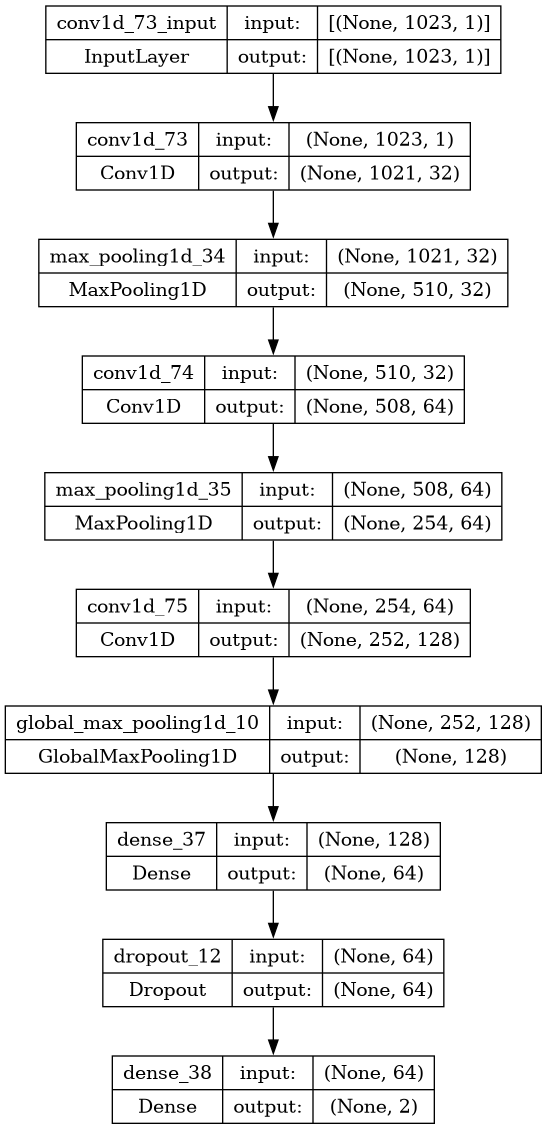

In [279]:
# Plot the model
from tensorflow.keras.utils import plot_model

# Generate the plot
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
